In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt


Read and Clean Data

In [2]:
data_path = '/content/drive/My Drive/Data/bluebookregression.csv'
car_dat = pd.read_csv(data_path)

# preview data
car_dat.head
print(car_dat)

# drop non-numeric columns
car_dat_num = car_dat.drop(columns=['Make', 'Model', 'Trim', 'Type'])

           Price  Mileage    Make     Model           Trim   Type  Cylinder  \
0    17314.10313     8221   Buick   Century       Sedan 4D  Sedan         6   
1    17542.03608     9135   Buick   Century       Sedan 4D  Sedan         6   
2    16218.84786    13196   Buick   Century       Sedan 4D  Sedan         6   
3    16336.91314    16342   Buick   Century       Sedan 4D  Sedan         6   
4    16339.17032    19832   Buick   Century       Sedan 4D  Sedan         6   
..           ...      ...     ...       ...            ...    ...       ...   
799  16507.07027    16229  Saturn  L Series  L300 Sedan 4D  Sedan         6   
800  16175.95760    19095  Saturn  L Series  L300 Sedan 4D  Sedan         6   
801  15731.13290    20484  Saturn  L Series  L300 Sedan 4D  Sedan         6   
802  15118.89323    25979  Saturn  L Series  L300 Sedan 4D  Sedan         6   
803  13585.63680    35662  Saturn  L Series  L300 Sedan 4D  Sedan         6   

     Liter  Doors  Cruise  Sound  Leather  
0      

Explore Data (correlations, scatterplots)

              Price       Mileage    Cylinder       Liter       Doors  \
count    804.000000    804.000000  804.000000  804.000000  804.000000   
mean   21343.143767  19831.934080    5.268657    3.037313    3.527363   
std     9884.852801   8196.319707    1.387531    1.105562    0.850169   
min     8638.930895    266.000000    4.000000    1.600000    2.000000   
25%    14273.073875  14623.500000    4.000000    2.200000    4.000000   
50%    18024.995020  20913.500000    6.000000    2.800000    4.000000   
75%    26717.316635  25213.000000    6.000000    3.800000    4.000000   
max    70755.466720  50387.000000    8.000000    6.000000    4.000000   

           Cruise       Sound     Leather  
count  804.000000  804.000000  804.000000  
mean     0.752488    0.679104    0.723881  
std      0.431836    0.467111    0.447355  
min      0.000000    0.000000    0.000000  
25%      1.000000    0.000000    0.000000  
50%      1.000000    1.000000    1.000000  
75%      1.000000    1.000000    1

<ipython-input-3-9395584ea6cd>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormat = car_dat.corr()


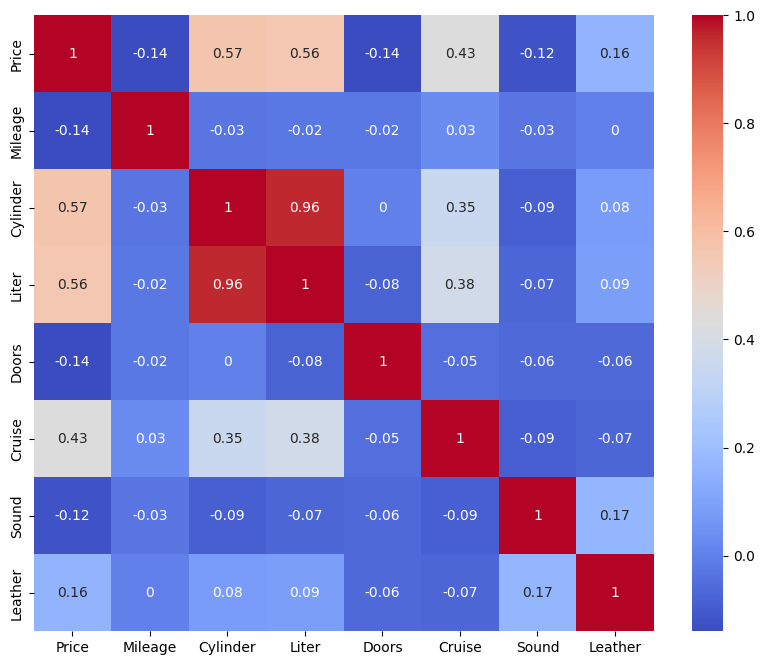

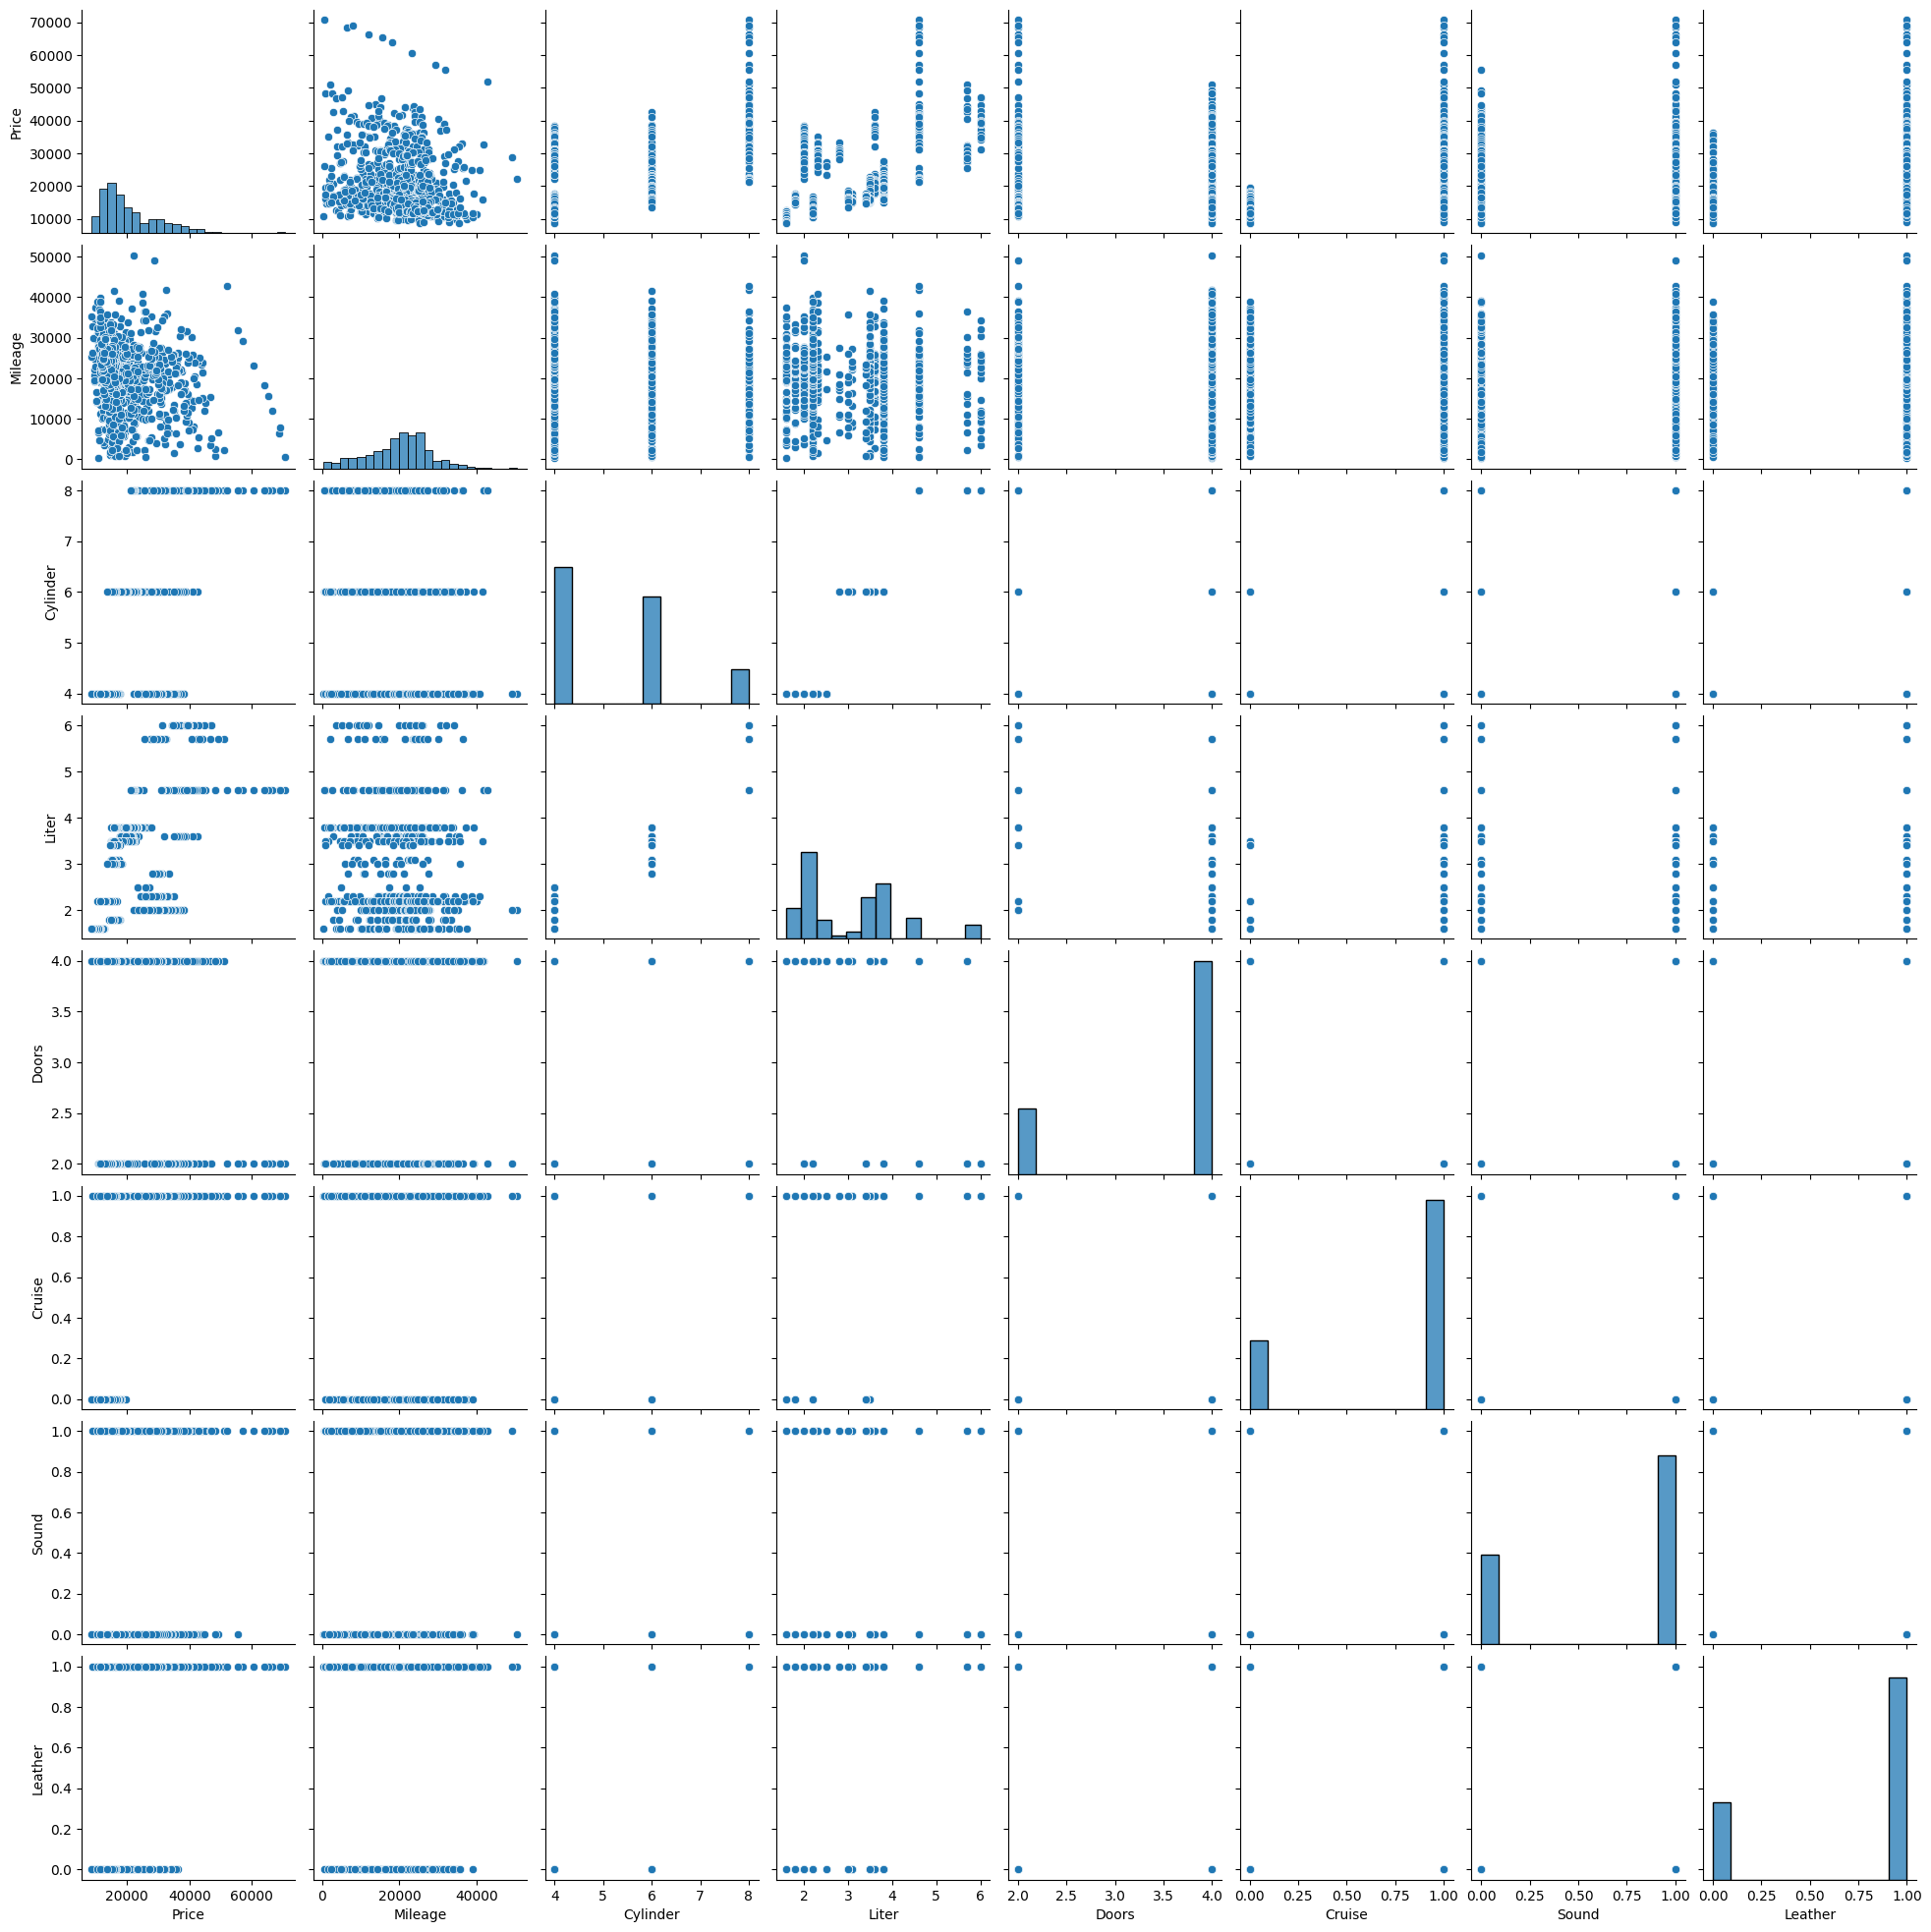

In [3]:
# Display summary statistics for numeric variables
print(car_dat.describe())

# Compute correlations
cormat = car_dat.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

# Create scatterplot matrix
sns.pairplot(car_dat.iloc[:,:12])
plt.show()

Fit a Simple Linear Regression of Price vs Mileage

In [4]:
# Perform linear regression
X = car_dat_num.drop(columns=['Price','Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather'])
y = car_dat['Price']
X = sm.add_constant(X)
reg1 = sm.OLS(y, X).fit()

# Display regression summary
print(reg1.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     16.75
Date:                Sat, 26 Aug 2023   Prob (F-statistic):           4.68e-05
Time:                        13:25:40   Log-Likelihood:                -8527.8
No. Observations:                 804   AIC:                         1.706e+04
Df Residuals:                     802   BIC:                         1.707e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.476e+04    904.363     27.383      0.0

Fit the Full Regression Model Using Only the Numeric Explanatory Variables

In [5]:
# Fit full regression
X = car_dat_num.drop(columns=['Price'])
y = car_dat['Price']
X = sm.add_constant(X)
fullreg = sm.OLS(y, X).fit()

# Display regression summary
print(fullreg.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     91.64
Date:                Sat, 26 Aug 2023   Prob (F-statistic):           8.80e-98
Time:                        13:25:46   Log-Likelihood:                -8298.5
No. Observations:                 804   AIC:                         1.661e+04
Df Residuals:                     796   BIC:                         1.665e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6758.7551   1876.967      3.601      0.0

Calculate Variance Inflation Factors (VIF) for full model

In [6]:
vifres = pd.DataFrame()
vifres["Variable"] = X.columns
vifres["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifres)


   Variable        VIF
0     const  51.894826
1   Mileage   1.004130
2  Cylinder  13.219830
3     Liter  13.518746
4     Doors   1.091984
5    Cruise   1.187814
6     Sound   1.049451
7   Leather   1.051753


Create function for automated Forward / Backward model selection

In [7]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS

    Arguments:
        X - pandas.DataFrame of numeric features
        y - vector, series of the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions

    Returns: list of selected features

    Example Call: stepwise_selection(X, y)
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.4f}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.4f}')
        if not changed:
           break
    return included


Automated Variable Selection

In [8]:
selected_features  = stepwise_selection(X, y)
print('resulting features:')
print(selected_features)

<ipython-input-7-e30aa04bf407>:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-7-e30aa04bf407>:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-7-e30aa04bf407>:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-7-e30aa04bf407>:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-7-e30aa04bf407>:26: FutureWarning: The defaul

Add  const with p-value 0.0000
Add  Cylinder with p-value 0.0000
Add  Cruise with p-value 0.0000
Add  Leather with p-value 0.0000
Add  Mileage with p-value 0.0000
Add  Doors with p-value 0.0000
Add  Sound with p-value 0.0004
resulting features:
['const', 'Cylinder', 'Cruise', 'Leather', 'Mileage', 'Doors', 'Sound']


<ipython-input-7-e30aa04bf407>:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-7-e30aa04bf407>:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-7-e30aa04bf407>:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


In [9]:
# Fit stepwise regression
X = car_dat_num[['Cylinder', 'Cruise', 'Leather', 'Mileage', 'Doors', 'Sound']]
X = sm.add_constant(X)
stepreg = sm.OLS(y, X).fit()

# Display regression summary
print(stepreg.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     106.8
Date:                Sat, 26 Aug 2023   Prob (F-statistic):           1.23e-98
Time:                        13:26:15   Log-Likelihood:                -8298.9
No. Observations:                 804   AIC:                         1.661e+04
Df Residuals:                     797   BIC:                         1.664e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7323.1643   1770.837      4.135      0.0

In [10]:
vifresstep = pd.DataFrame()
vifresstep["Variable"] = X.columns
vifresstep["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifresstep)


   Variable        VIF
0     const  46.202290
1  Cylinder   1.167272
2    Cruise   1.164616
3   Leather   1.049990
4   Mileage   1.003421
5     Doors   1.010767
6     Sound   1.045804


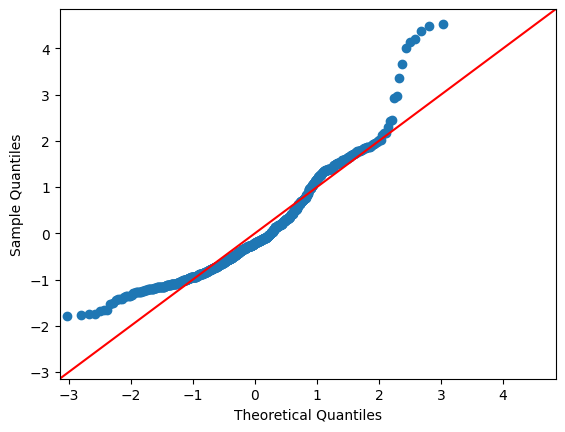

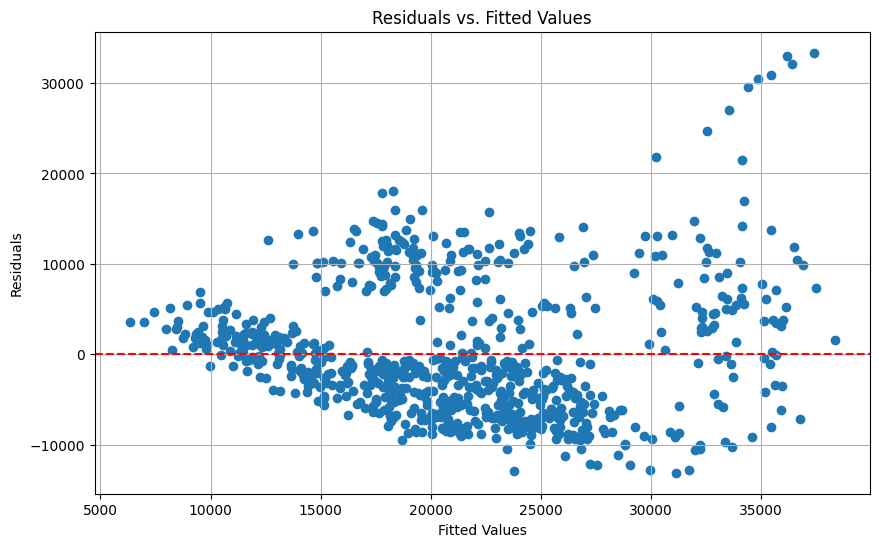

In [14]:
# Calculate residuals
residuals = stepreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals,fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(stepreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

Try a log transformation and a square root transformation and compare the results

In [15]:
# log transformed regression
X = car_dat_num[['Cylinder', 'Cruise', 'Leather', 'Mileage', 'Doors', 'Sound']]
X = sm.add_constant(X)
logy = np.log(y)
logreg = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     124.4
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          7.76e-111
Time:                        13:40:51   Log-Likelihood:                -158.01
No. Observations:                 804   AIC:                             330.0
Df Residuals:                     797   BIC:                             362.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2003      0.071    129.744      0.0

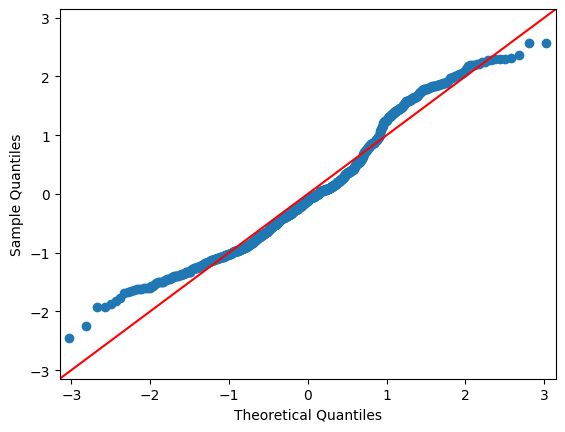

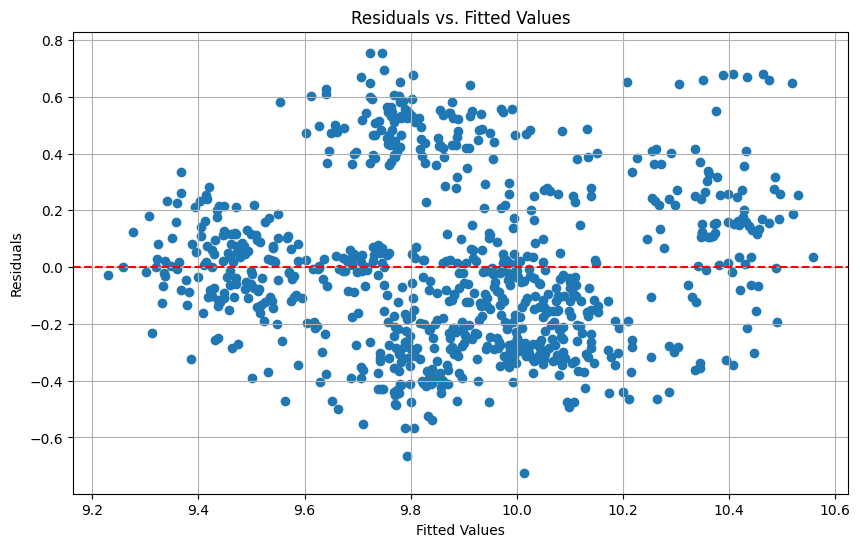

In [16]:
# Calculate residuals
residuals = logreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [17]:
# Square Root transformed regression
X = car_dat_num[['Cylinder', 'Cruise', 'Leather', 'Mileage', 'Doors', 'Sound']]
X = sm.add_constant(X)
sqrty = np.sqrt(y)
sqrtreg = sm.OLS(sqrty, X).fit()

# Display regression summary
print(sqrtreg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     117.3
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          5.20e-106
Time:                        13:44:06   Log-Likelihood:                -3646.7
No. Observations:                 804   AIC:                             7307.
Df Residuals:                     797   BIC:                             7340.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.7522      5.435     17.434      0.0

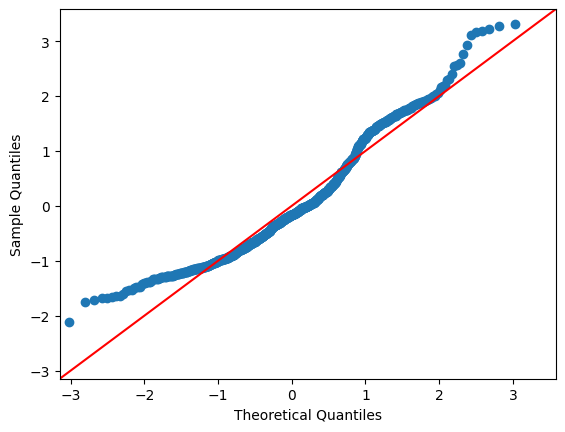

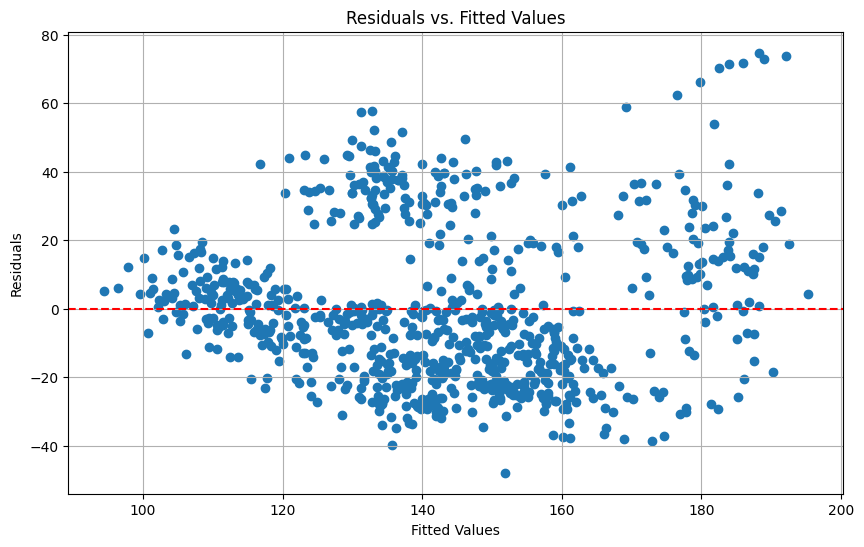

In [18]:
# Calculate residuals
residuals = sqrtreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(sqrtreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

Examine the relationships between Make and Type of the car and price using boxplots

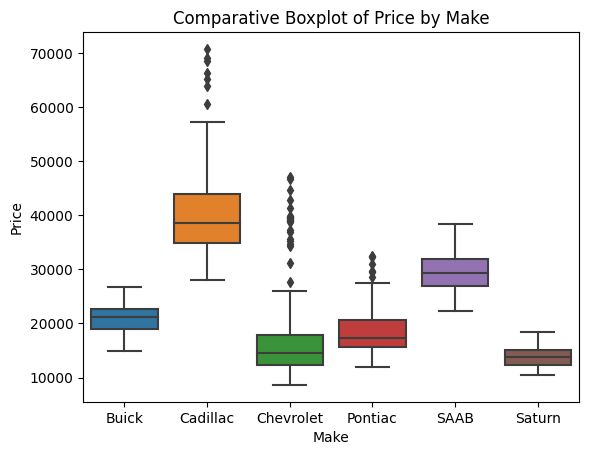

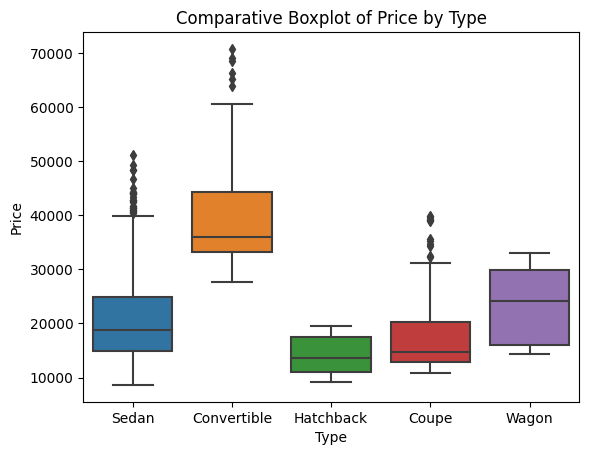

In [24]:
#Look at Make vs Price
sns.boxplot(x="Make", y="Price", data=car_dat)

# Add labels and a title
plt.xlabel("Make")
plt.ylabel("Price")
plt.title("Comparative Boxplot of Price by Make")

# Show the plot
plt.show()

#Look at Type vs Price
sns.boxplot(x="Type", y="Price", data=car_dat)

# Add labels and a title
plt.xlabel("Type")
plt.ylabel("Price")
plt.title("Comparative Boxplot of Price by Type")

# Show the plot
plt.show()



In [23]:
# log transformed regression including categorical variables
X = car_dat[['Make', 'Type', 'Cylinder', 'Cruise', 'Leather', 'Mileage', 'Doors', 'Sound']]
X = pd.get_dummies(X, columns=['Make', 'Type'], drop_first=True)
X = sm.add_constant(X)
logy = np.log(y)
logreg2 = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     736.9
Date:                Sat, 26 Aug 2023   Prob (F-statistic):               0.00
Time:                        14:10:50   Log-Likelihood:                 639.35
No. Observations:                 804   AIC:                            -1249.
Df Residuals:                     789   BIC:                            -1178.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.3036      0.037    195.

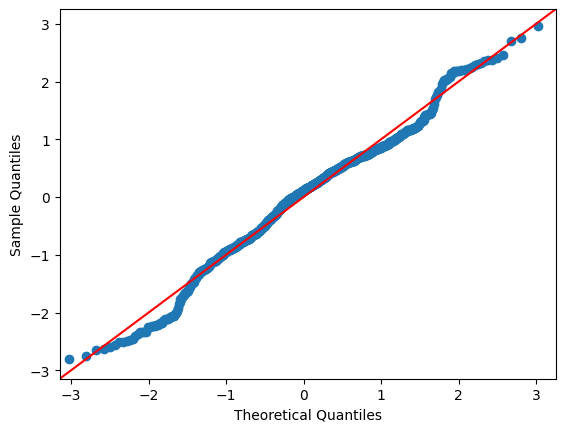

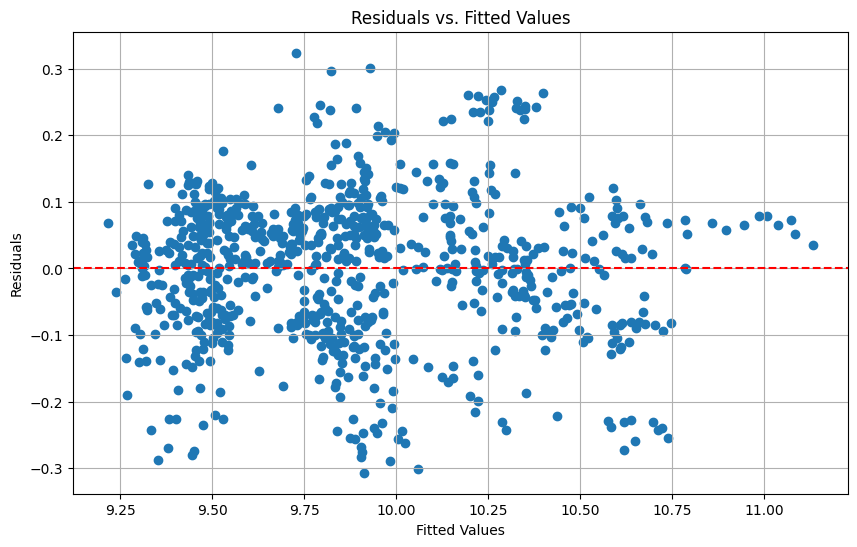

In [25]:
# Calculate residuals
residuals = logreg2.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logreg2.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

Use two simple models to explore the effect of interaction terms on the model

In [27]:
# Fit Model using mileage and cylinder without interaction
X = car_dat_num[['Cylinder', 'Mileage']]
X = sm.add_constant(X)
reg1 = sm.OLS(y, X).fit()

# Display regression summary
print(reg1.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     206.2
Date:                Sat, 26 Aug 2023   Prob (F-statistic):           5.95e-73
Time:                        14:46:43   Log-Likelihood:                -8369.2
No. Observations:                 804   AIC:                         1.674e+04
Df Residuals:                     801   BIC:                         1.676e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3145.7503   1325.934      2.372      0.0

In [28]:
# Fit Model using mileage and cylinder including interaction
X = car_dat_num[['Cylinder', 'Mileage']]
X['cyl*mile'] = X['Cylinder'] * X['Mileage']
X = sm.add_constant(X)
reg1int = sm.OLS(y, X).fit()

# Display regression summary
print(reg1int.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     142.9
Date:                Sat, 26 Aug 2023   Prob (F-statistic):           3.67e-74
Time:                        14:46:53   Log-Likelihood:                -8363.6
No. Observations:                 804   AIC:                         1.674e+04
Df Residuals:                     800   BIC:                         1.675e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5279.7364   2836.157     -1.862      0.0

<ipython-input-28-a404c669b4c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cyl*mile'] = X['Cylinder'] * X['Mileage']
